# Table of Contents
0. [Introduction](#intro)
    * 0.1 [Libraries](#libraries)
    * 0.2 [Loading the Dataset](#loading-data)
1. [Exploratory Data Analysis](#data-exploration)
   * 1.1 [Overview](#overview)
   * 1.2 [Dealing with Missing Values](#missing-vals)
   * 1.3 [Dealing with Outliers](#outliers)
   * 1.4 [Exploring Numerical Attributes](#ena)
   * 1.5 [Exploring Categorical Attributes](#eca)
2. [Features Engineering & Transformation](#feateng)
   * 2.1 [Binning Continuous Variables](#bin)
   * 2.2 [Label Encoding Non-Numeric Features](#le)
   * 2.3 [One-Hot Encoding Categorical Features](#ohe)
   * 2.4 [Dropping Unrelated Columns](#drop)
3. [Model Training](#model)
   * 3.1 [Train-Test Split](#train-test)
   * 3.2 [Logistic Regression Baseline](#logreg)
       * 3.2.1 [Logistic Regression Feature Importance](#lrfi)
   * 3.3 [Random Forest](#randfor)
   * 3.4 [Model Ensembling](#ens)
4. [Conclusion](#concl)


# 0. Introduction

tldr: The goal is to minimize number of customers switching to competitors or discontinuing their contracts.

In order to do so, a model can be trained on an existing dataset, which can internalize and weigh important attributes of customers
who will likely be loyal.

The model would be able to predict customers who will likely be churn and attention should be paid to target customers with
these attributes, through pricing/ promotions

This kernel has 3 main parts: Exploratory Data Analysis, Feature Engineering and Model Training

## 0.1 Libraries <a name="libraries"></a>

In [65]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

%matplotlib inline

## 0.2 Loading the dataset <a name="loading-data"></a>

There are 7,043 observations (rows) with 21 attributes (columns) in the dataset

In [3]:
df = pd.read_csv('churn_data.csv')
df.shape

(7043, 21)

## 1. Exploratory Data Analysis <a name="data-exploration"></a>

## 1.1 Overview <a name="overview"></a>

There are 2 types of data, categorical and numerical

* ```customerID``` represents each customer and do not have an effect on churn
* ```gender``` is binary (Male/Female)
* ```SeniorCitizen``` is binary
    * 1 - Senior Citizen
    * 0 - Others
* ```Partner``` is binary
    * Yes - customer has a partner
    * No - customer do not have a partner
* ```Dependents``` is binary
    * Yes - customer has dependents
    * No - customer do not have dependents
* ```tenure``` is numerical
    * Represents how long the customer have been using the service
* ```PhoneService``` is binary
    * Yes - customer has phone service with company
    * no - customer do not have phone service with company
* ```MultipleLines``` is categorical
    * Yes - customer has multiple line subscriptions
    * No - customer has only 1 line subscription
    * No phone service - customer do not have phone service with company
* ```InternetService``` is categorical
    * DSL
    * Fiber optic
    * No - customer do not have internet service with company
* ```OnlineSecurity``` is categorical
    * Yes - customer has online security with company
    * No - customer do not have online security with company
    * No internet service - customer do not have internet service with company
* ```OnlineBackup```, ```DeviceProtection```, ```TechSupport```, ```StreamingTV```, ```StreamingMovies``` are similar to ```OnlineSecurity``` (all categorical with same possible values)

* ```Contract``` is categorical
    * Customers contract arrangement, can be either of these: ['Month-to-month' 'One year' 'Two year']
* ```PaperlessBilling``` is binary
    * How customers are billed (either electronic ('Yes') or through a paper bill ('No'))
* ```PaymentMethod``` is categorical (self-explanatory), can be either of these: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)', 'Credit card (automatic)']
* Finally, we have ```MonthlyCharges```, ```TotalCharges``` and ```Churn```

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(3), obje

In [5]:
def print_df_unique_vals(df):
    for col in df.columns:
        unique_vals = df[col].unique()
        if len(unique_vals) < 10:
            print("Unique values for column {}: {}".format(col, unique_vals))
        else:
            if is_string_dtype(df[col]):
                print("column {} has values string type".format(col))
            elif is_numeric_dtype(df[col]):
                print("column {} is numerical".format(col))

In [6]:
print_df_unique_vals(df)

column customerID is numerical
Unique values for column gender: ['Female' 'Male']
Unique values for column SeniorCitizen: [0 1]
Unique values for column Partner: ['Yes' 'No']
Unique values for column Dependents: ['No' 'Yes']
column tenure is numerical
Unique values for column PhoneService: ['No' 'Yes']
Unique values for column MultipleLines: ['No phone service' 'No' 'Yes']
Unique values for column InternetService: ['DSL' 'Fiber optic' 'No']
Unique values for column OnlineSecurity: ['No' 'Yes' 'No internet service']
Unique values for column OnlineBackup: ['Yes' 'No' 'No internet service']
Unique values for column DeviceProtection: ['No' 'Yes' 'No internet service']
Unique values for column TechSupport: ['No' 'Yes' 'No internet service']
Unique values for column StreamingTV: ['No' 'Yes' 'No internet service']
Unique values for column StreamingMovies: ['No' 'Yes' 'No internet service']
Unique values for column Contract: ['Month-to-month' 'One year' 'Two year']
Unique values for column Pap

There is something off about TotalCharges. On inspection, total charges should be numerical but yet that column is showing as a string type. Let's find out why that is the case using regex

In [7]:
dec_reg_exp = r'^[+-]{0,1}((\d*\.)|\d*)\d+$'
abnormal_total_charges = df[~df.TotalCharges.str.contains(dec_reg_exp)]
abnormal_total_charges

c:\users\work-pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,489,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,754,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,937,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,1083,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1341,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,3332,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3827,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,4381,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,5219,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,6671,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


The TotalCharges for these observations need to be imputed or dropped

The percentage of blank values is about 0.15%, it is an insignificant portion of the entire dataset

Let's drop these observations

In [8]:
df = df[df.TotalCharges.str.contains(dec_reg_exp)]
df['TotalCharges'] = df['TotalCharges'].astype(float)

c:\users\work-pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


## 1.2 Dealing with Missing Values <a name="missing-vals"></a>

Checking if there are columns with missing values is paramount. It is fortunate that the data has no missing value and requires no imputation

In [9]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    

display_missing(df)

customerID column missing values: 0
gender column missing values: 0
SeniorCitizen column missing values: 0
Partner column missing values: 0
Dependents column missing values: 0
tenure column missing values: 0
PhoneService column missing values: 0
MultipleLines column missing values: 0
InternetService column missing values: 0
OnlineSecurity column missing values: 0
OnlineBackup column missing values: 0
DeviceProtection column missing values: 0
TechSupport column missing values: 0
StreamingTV column missing values: 0
StreamingMovies column missing values: 0
Contract column missing values: 0
PaperlessBilling column missing values: 0
PaymentMethod column missing values: 0
MonthlyCharges column missing values: 0
TotalCharges column missing values: 0
Churn column missing values: 0




## 1.3 Dealing with Outliers <a name="outliers"></a>
Outliers need to be checked for too as they may skew a model's prediction

In [10]:
# Summary statistics:
cont_features = ["tenure", "MonthlyCharges", "TotalCharges"]
df_num = df[cont_features]
df_num.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


1 way we can check for outliers is to use the interquartile range. The IQR is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles. From the results below, it seems that there are no outliers. 

In [11]:
Q1 =df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
IQR
((df_num < (Q1 - 1.5 * IQR)) |(df_num > (Q3 + 1.5 * IQR))).any()

tenure            False
MonthlyCharges    False
TotalCharges      False
dtype: bool

## 1.4 Exploring Numerical Attributes <a name="ena"></a>

The visualizations below show the distribution plot of the numerical attributes, split by Churn and non-Churn

* For tenure: The longer the tenure, the more non-Churn customers outweigh Churn customers. The converse holds true, the shorter the tenure, the more Churn customers outweigh non-Churn customers. This fits the intuition as the longer the customer stick wit the Telco company, the less likely he/she is to switch to another Telco 


* For MonthlyCharges: The less the charge, the more non-Churn customers outweigh Churn customers. The converse holds true, the higher the charge, the more Churn customers outweigh non-Churn customers. This fits the intuition that the more the customer is charged per month, the more likely it is that the customer will switch to another Telco.


* For TotalCharges: The more the charge, the more non-Churn customers outweigh Churn customers. The converse holds true, the lower the charge, the more Churn customers outweigh non-Churn customers. This could mean that the total lifetime charge for that customer by the Telco is lower for customers that switch as compared to those customers that don't switch

In [12]:
churn = df['Churn'] == 'Yes'

In [13]:
def plot_dist_num_cols_target(df, cont_features, target, target_label):
    fig, axs = plt.subplots(ncols=1, nrows=len(cont_features), figsize=(20, 20))
    plt.subplots_adjust(right=1.5)
    for i, feature in enumerate(cont_features):    
        sns.distplot(df[~target][feature], label='Not {}'.format(target_label), hist=True, color='#e74c3c', ax=axs[i])
        sns.distplot(df[target][feature], label='{}'.format(target_label), hist=True, color='#2ecc71', ax=axs[i])
        
        axs[i].set_xlabel('')
        axs[i].set_xlabel('')
        
        for j in range(len(cont_features)):        
            axs[j].tick_params(axis='x', labelsize=15)
            axs[j].tick_params(axis='y', labelsize=15)

        axs[i].legend(loc='upper right', prop={'size': 10})
        axs[i].legend(loc='upper right', prop={'size': 10})
        axs[i].set_title('Distribution of {} in {}'.format(target_label, feature), size=20, y=1.05)

    plt.tight_layout(pad=5)
    plt.show()

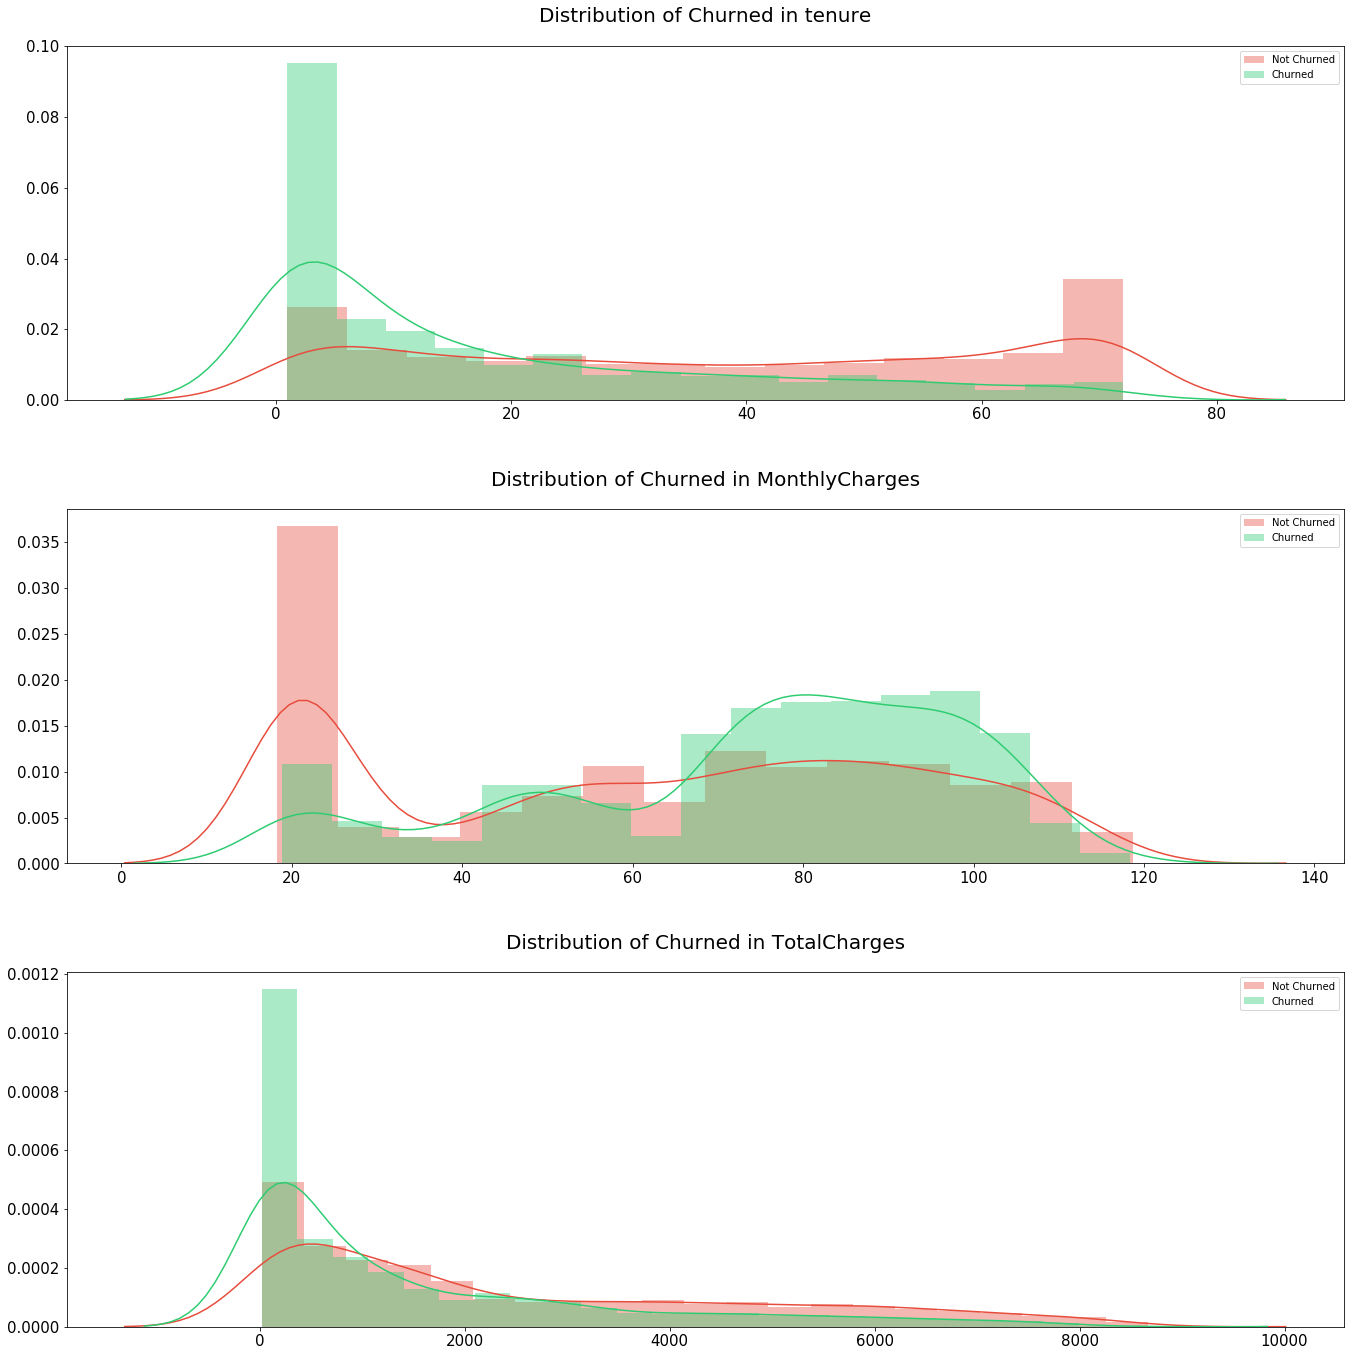

In [14]:
plot_dist_num_cols_target(df, cont_features, churn, 'Churned')

The visualizations below show the distribution plot of the numerical attributes

In [15]:
def plot_dist_num_cols_target(df, cont_features):
    fig, axs = plt.subplots(ncols=1, nrows=len(cont_features), figsize=(20, 20))
    plt.subplots_adjust(right=1.5)
    for i, feature in enumerate(cont_features):    
        sns.distplot(df[feature], label='{}'.format(feature), hist=False, color='#e74c3c', ax=axs[i])
        
        axs[i].set_xlabel('')
        axs[i].set_xlabel('')
        
        for j in range(len(cont_features)):        
            axs[j].tick_params(axis='x', labelsize=15)
            axs[j].tick_params(axis='y', labelsize=15)

        axs[i].legend(loc='upper right', prop={'size': 10})
        axs[i].legend(loc='upper right', prop={'size': 10})
        axs[i].set_title('Distribution of {} feature'.format(feature), size=20, y=1.05)

    plt.tight_layout(pad=5)
    plt.show()

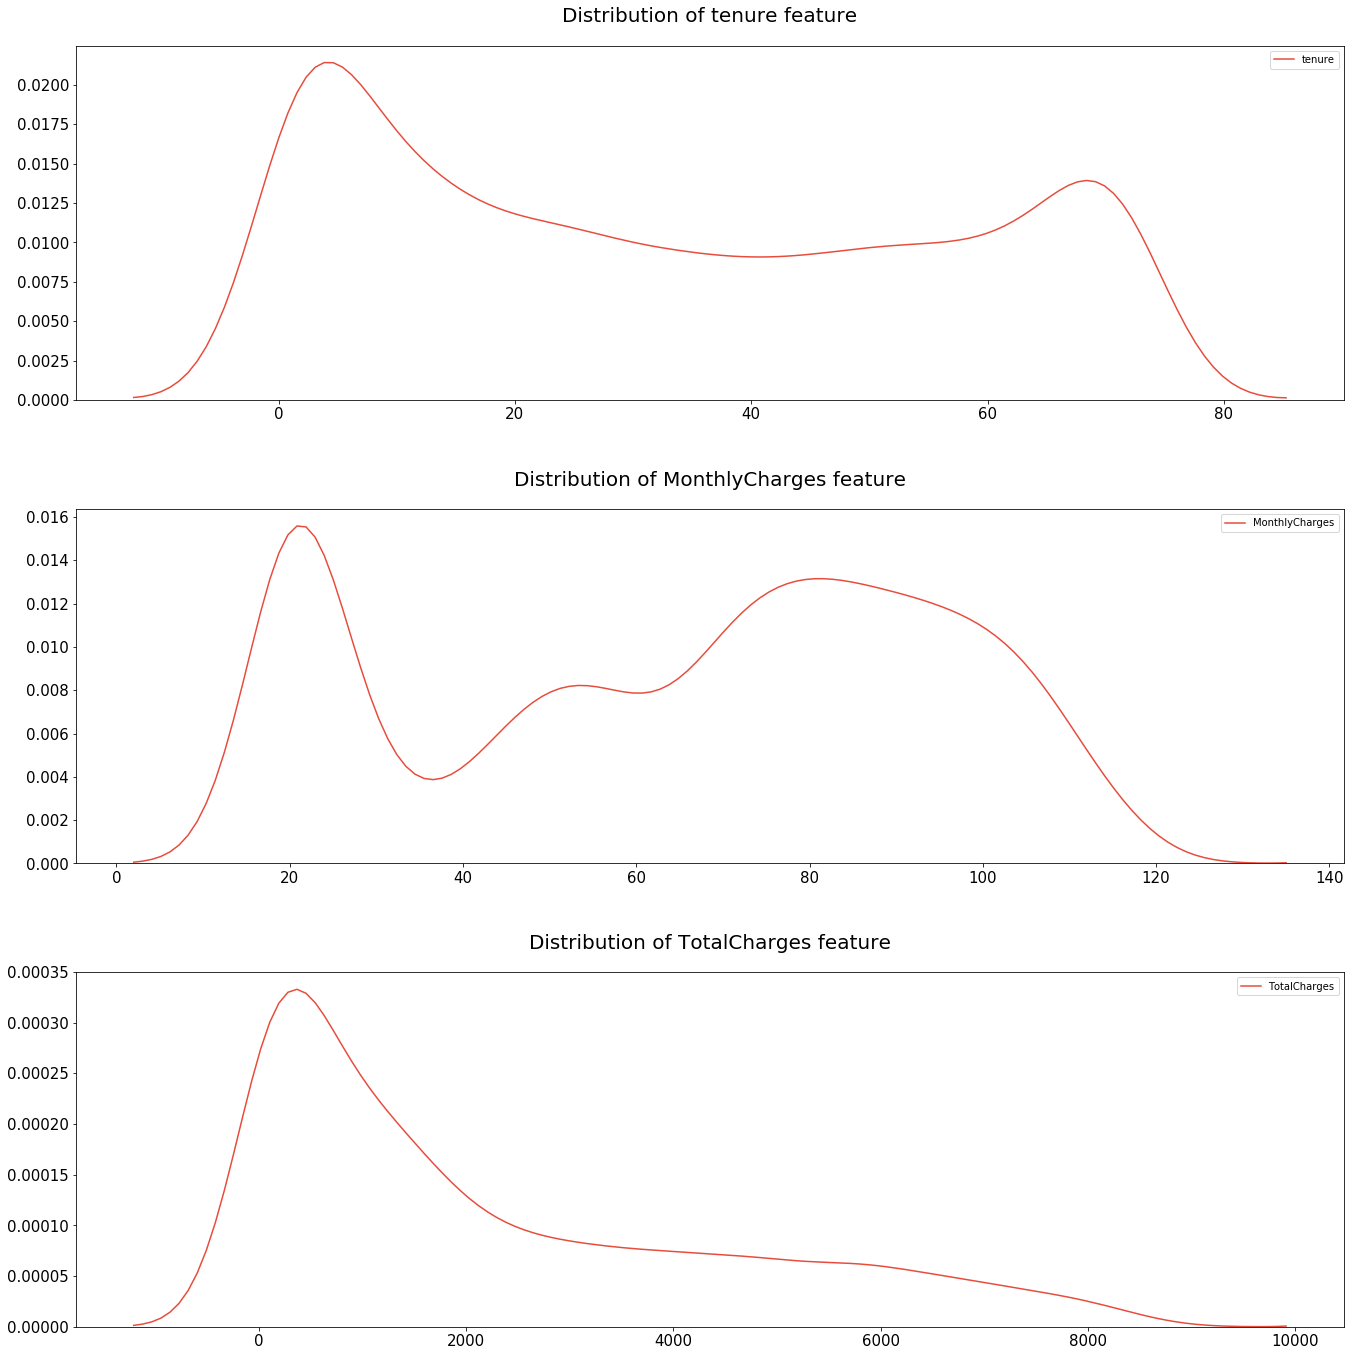

In [16]:
plot_dist_num_cols_target(df, cont_features)

## 1.5 Exploring Categorical Attributes <a name="eca"></a>

* For all classes of categorical variables, for all the classes, it looks like customers that are not churned outnumber customers that are churned.

* For gender, males and females have almost equal number of churned and non-churned customers

* For other categorical variables, there is at least 1 class with number of churned customers outnumbering the number of non-churned customers

* On first glance, a simple classification model likely is not good enough as categorical variables are not highly separable to churned and non-churned customers.

* Target variable has uneven distribution, with number of customers not churned, greatly outnumbering number of churned customers in total by more than double

In [17]:
cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
               'Contract', 'PaperlessBilling', 'PaymentMethod']

In [18]:
def plot_bar_cat_cols(df, cat_features, target_label, hue):
    fig, axs = plt.subplots(ncols=2, nrows=8, figsize=(50, 50))
    plt.subplots_adjust(right=1.5, top=1.25)
    for i, feature in enumerate(cat_features, 1):    
        plt.subplot(8, 2, i)
        sns.countplot(x=feature, hue=hue, data=df)
        plt.xlabel('{}'.format(feature), size=30, labelpad=15)
        plt.ylabel('Customer Count', size=30, labelpad=15)    
        plt.tick_params(axis='x', labelsize=30)
        plt.tick_params(axis='y', labelsize=30)

        plt.legend(['Not {}'.format(target_label), '{}'.format(target_label)], loc='upper right', prop={'size': 25})
        plt.title('Count of {} in {} Feature'.format(target_label, feature), size=40, y=1.05)

    plt.tight_layout(h_pad=5)
    plt.show()

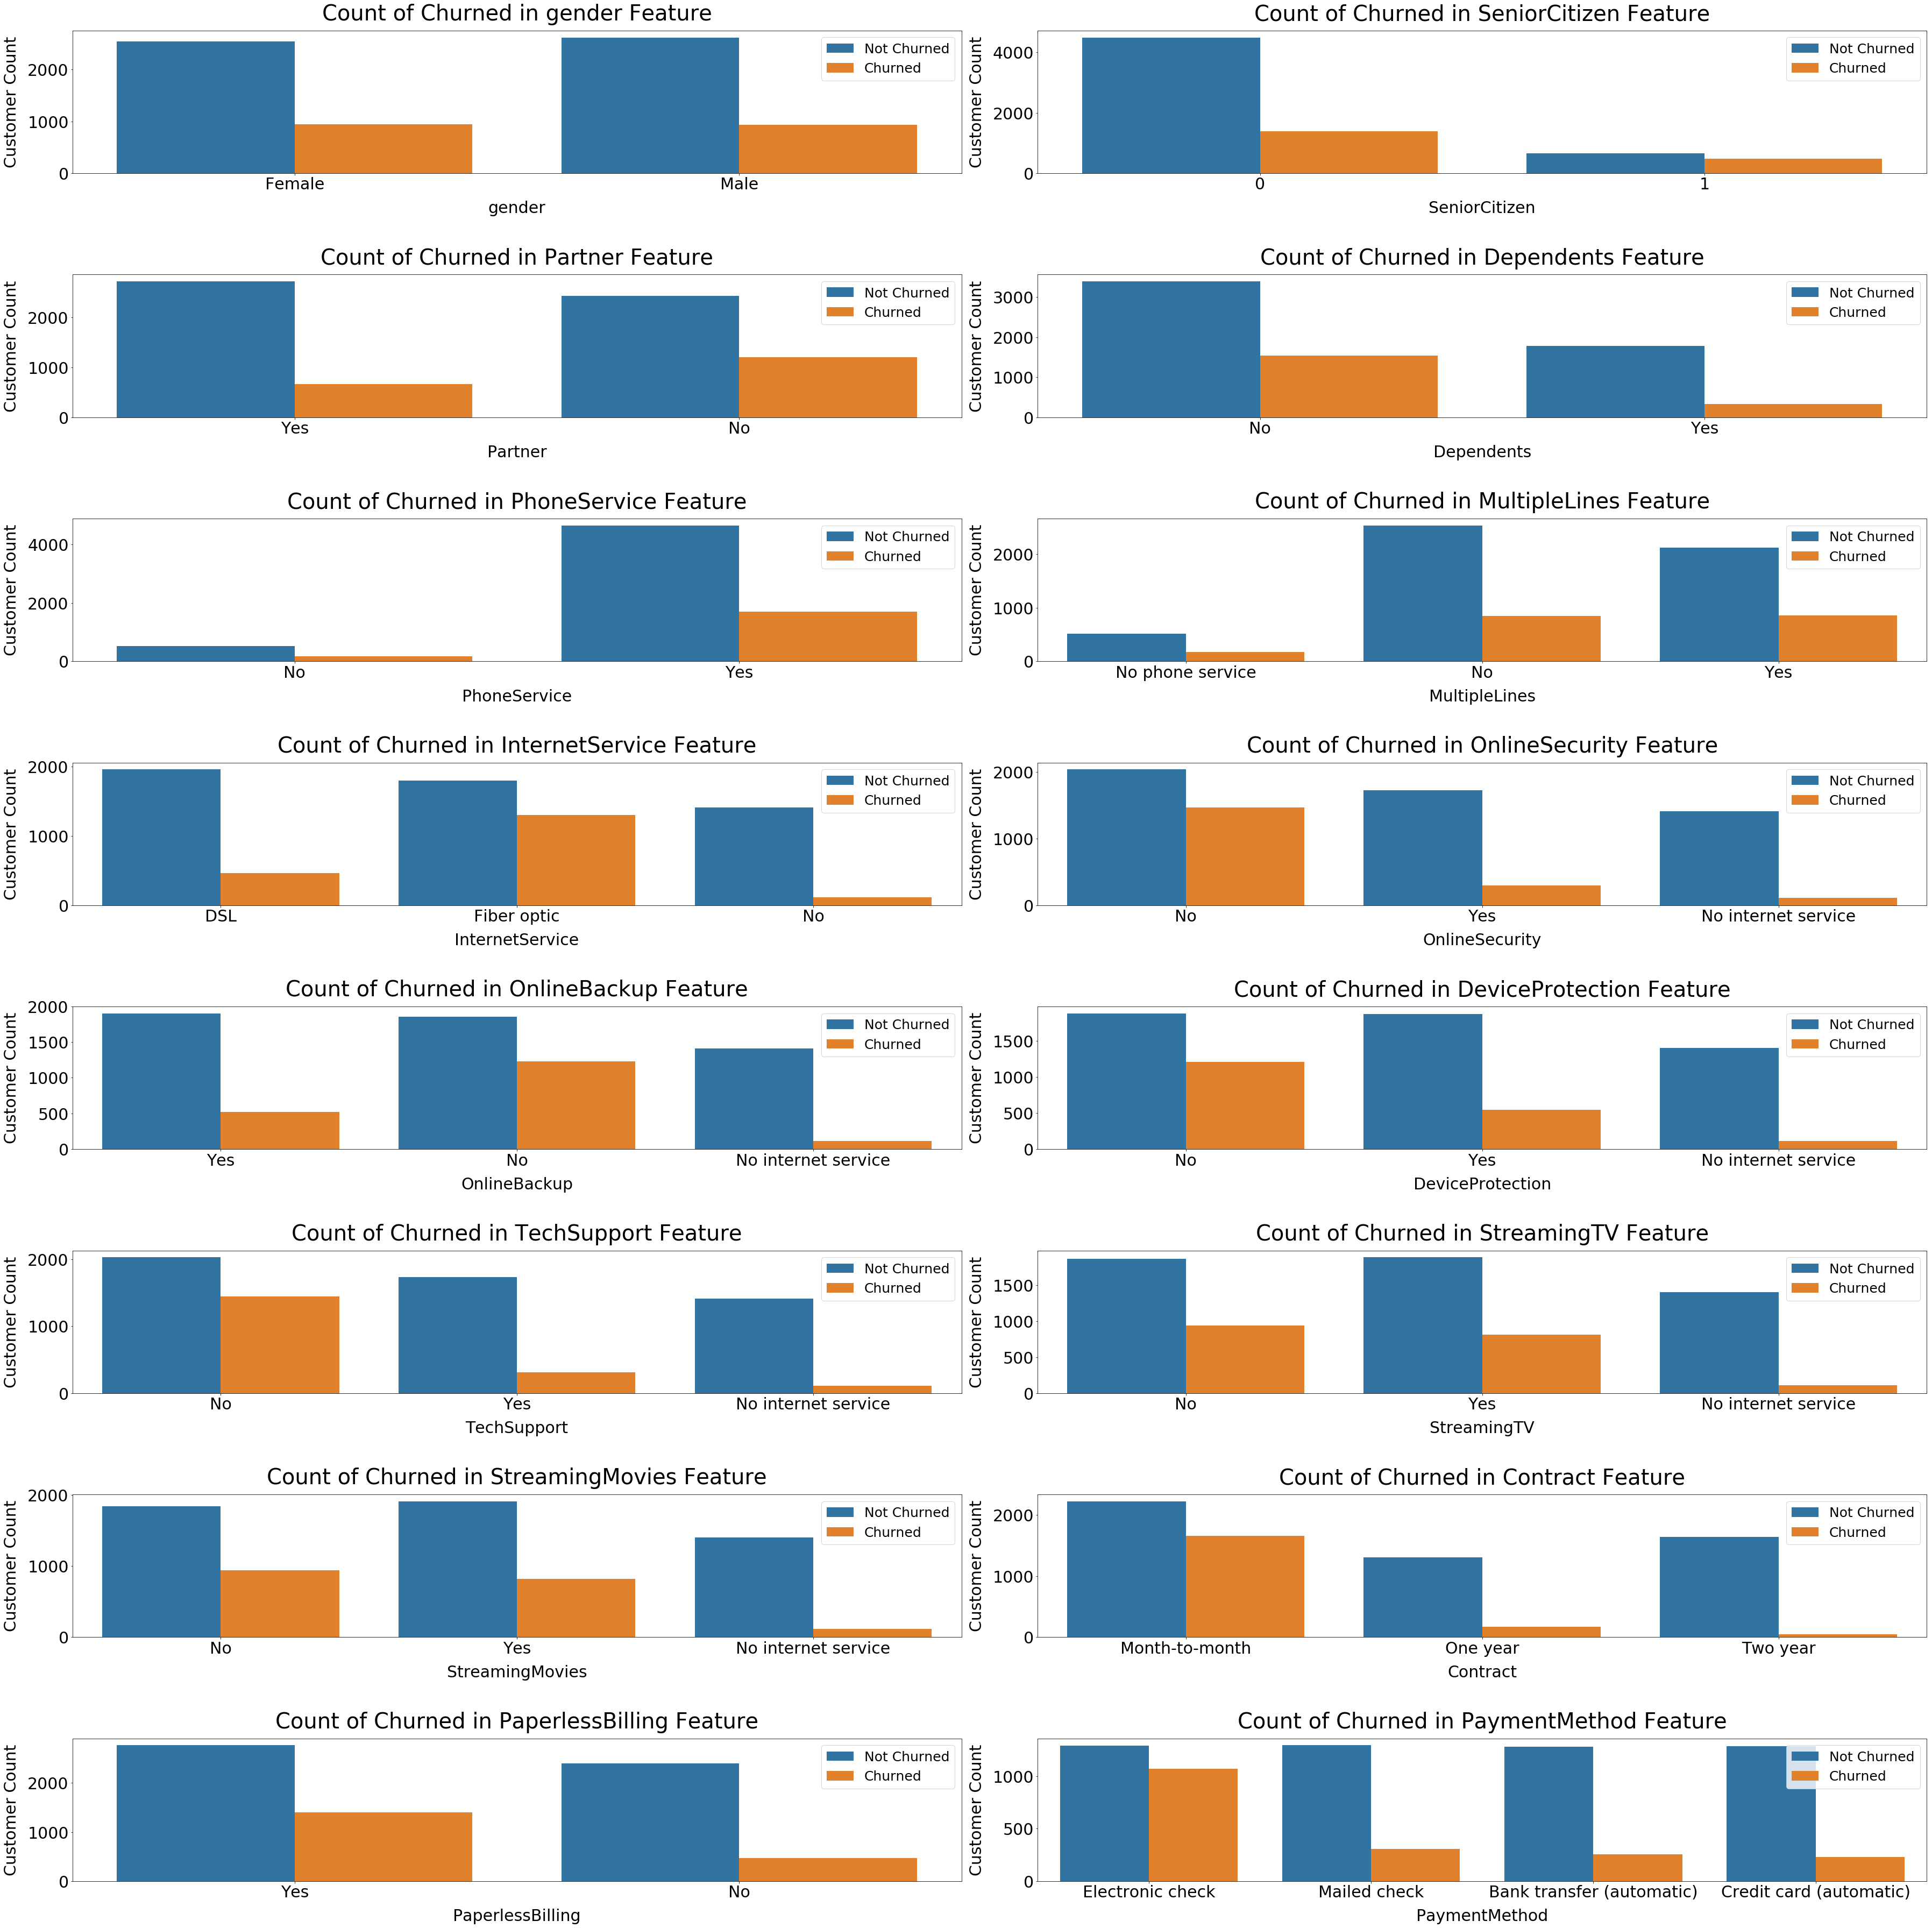

In [19]:
plot_bar_cat_cols(df, cat_features, 'Churned', 'Churn')

Let's take a look at count distribution of the dependent variable

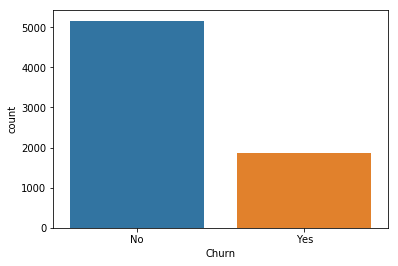

In [20]:
sns.countplot(x="Churn", data=df)

## 2. Features Engineering & Transformation <a name="feateng"></a>

## 2.1 Binning Continuous Variables <a name="bin"></a>

* Tenure looks to be separable according to churned and not churned customers. The higher the tenure, the less likely it is that customers will be churned.

* Similarly, for TotalCharges, the higher the TotalCharges, the less likely it is that customers will be churned.

* For MonthlyCharges, it is uneven. There are groups in the middle that have churned customers outnumbering customers that are not churned. There are also groups in the middle that have customers that are not churned outnumering customers that are churned. To account for these groups, let's bin MonthlyCharges

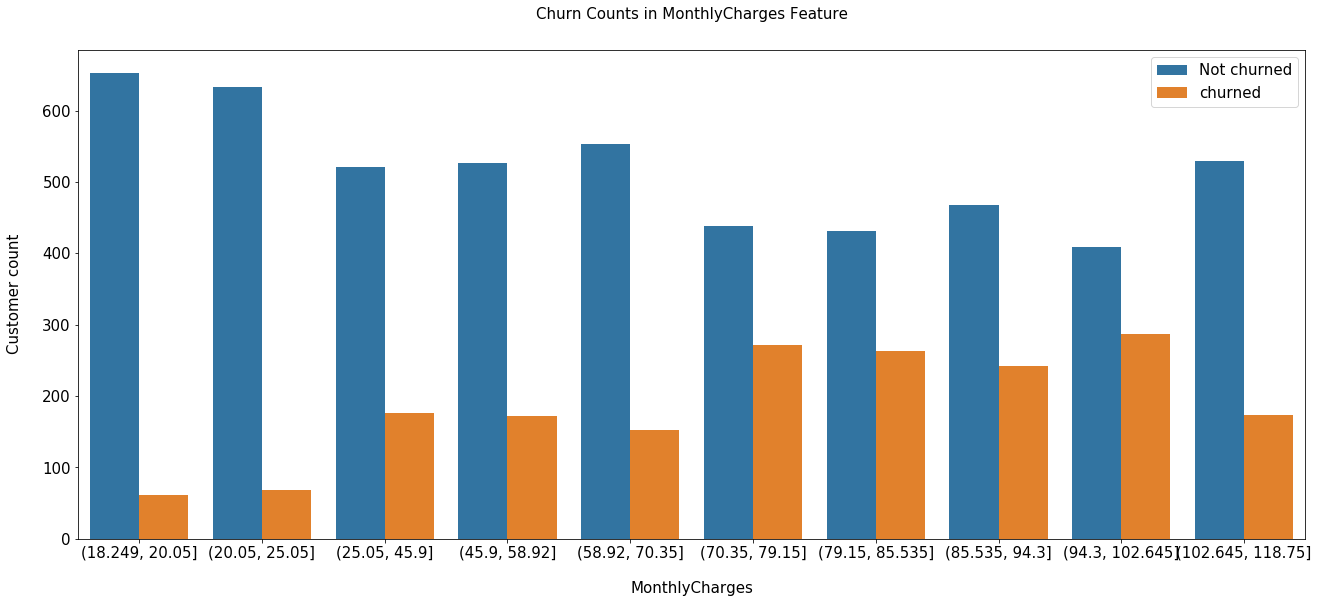

In [21]:
df['MonthlyCharges'] = pd.qcut(df['MonthlyCharges'], 10)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='MonthlyCharges', hue='Churn', data=df)

plt.xlabel('MonthlyCharges', size=15, labelpad=20)
plt.ylabel('Customer count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not churned', 'churned'], loc='upper right', prop={'size': 15})
plt.title('Churn Counts in {} Feature'.format('MonthlyCharges'), size=15, y=1.05)

plt.show()

**Fare**

* It can be seen that, the higher the MonthlyCharges, the higher the proportion of customers that are churned compared to customers that are not churned. 

* The group at the highest extreme (102.645, 118.75] is unusual, where churned customers are comparable in proportion to groups in the middle. 

* This grup is captured when we bin as compared to not binning

## 2.2 Label Encoding Non-Numeric Features  <a name="le"></a>

* gender, Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, Churn are object type and MonthlyCharges is categorical. 

* They are converted to numerical type with LabelEncoder.

In [22]:
non_numeric_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'Churn']

for feature in non_numeric_features:        
    df[feature] = LabelEncoder().fit_transform(df[feature])

In [23]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,2,29.85,0
1,2,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,3,1889.50,0
2,3,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,3,108.15,1
3,4,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,2,1840.75,0
4,5,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,5,151.65,1


In [24]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7032 non-null int64
gender              7032 non-null int32
SeniorCitizen       7032 non-null int64
Partner             7032 non-null int32
Dependents          7032 non-null int32
tenure              7032 non-null int64
PhoneService        7032 non-null int32
MultipleLines       7032 non-null int32
InternetService     7032 non-null int32
OnlineSecurity      7032 non-null int32
OnlineBackup        7032 non-null int32
DeviceProtection    7032 non-null int32
TechSupport         7032 non-null int32
StreamingTV         7032 non-null int32
StreamingMovies     7032 non-null int32
Contract            7032 non-null int32
PaperlessBilling    7032 non-null int32
PaymentMethod       7032 non-null int32
MonthlyCharges      7032 non-null int32
TotalCharges        7032 non-null float64
Churn               7032 non-null int32
dtypes: float64(1), int32(17), int64(3)
memory usag

## 2.2 One-Hot Encoding Categorical Features  <a name="ohe"></a>

* The categorical features are one-hot encoded (except for binary variables). 

* MonthlyCharges is not one-hot encoded as it is an ordinal variable

In [25]:
cat_features = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                'PaymentMethod']
encoded_features = []

for feature in cat_features:
    encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
    n = df[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df.index
    encoded_features.append(encoded_df)

c:\users\work-pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
c:\users\work-pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence thi

In [26]:
len(encoded_features)

10

In [27]:
df = pd.concat([df, *encoded_features], axis=1)

## 2.3 Dropping Unrelated Columns  <a name="drop"></a>

Drop columns that are unrelated (customerID) and columns where we generate one-hot encoded variables earlier

In [28]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'MultipleLines_1', 'MultipleLines_2', 'MultipleLines_3',
       'InternetService_1', 'InternetService_2', 'InternetService_3',
       'OnlineSecurity_1', 'OnlineSecurity_2', 'OnlineSecurity_3',
       'OnlineBackup_1', 'OnlineBackup_2', 'OnlineBackup_3',
       'DeviceProtection_1', 'DeviceProtection_2', 'DeviceProtection_3',
       'TechSupport_1', 'TechSupport_2', 'TechSupport_3', 'StreamingTV_1',
       'StreamingTV_2', 'StreamingTV_3', 'StreamingMovies_1',
       'StreamingMovies_2', 'StreamingMovies_3', 'Contract_1', 'Contract_2',
       'Contract_3', 'PaymentMethod_1', 'PaymentMethod_2', 'PaymentMethod_3',
       'Payment

In [29]:
df2 = df.copy()

In [30]:
drop_cols = ['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 
            'StreamingTV', 'StreamingMovies', 'Contract', 
            'PaymentMethod']

df.drop(columns=drop_cols, inplace=True)

## 3. Model Training  <a name="model"></a>

2 models are trained to predict churn given customer characteristics

1. Logistic Regression (Baseline)
2. Random Forest

## 3.1 Train-Test Split <a name="train-test"></a>

Train-test split

Data is split into 80% training data and 20% test data

In [31]:
X = df.drop(columns=['Churn']).values
y = df["Churn"].values

seed = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  stratify=y, random_state=seed)
print('X_train shape: {}'.format(x_train.shape))
print('X_test shape: {}'.format(x_test.shape))

X_train shape: (5625, 40)
X_test shape: (1407, 40)


## 3.2 Logistic Regression Baseline <a name="logreg"></a>

* We run stratifiedKFolds cross validation to check cross-validation results

* The logistic regression model has a difficult time predicting churn. 
* The sensitivity is about 57%, meaning it is only about to predict 57% of churned customers correct out of all of the possible churned customers in our test dataset.


In [32]:
skf = StratifiedKFold(n_splits=5)
fprs, tprs, scores, val_auc_scores = [], [], [], []
for train_index, valid_index in skf.split(x_train, y_train):
    x_pseudo_train, x_pseudo_valid = x_train[train_index], x_train[valid_index]
    y_pseudo_train, y_pseudo_valid = y_train[train_index], y_train[valid_index]
    ss = StandardScaler()
    x_pseudo_train_scaled = ss.fit_transform(x_pseudo_train)
    x_pseudo_valid_scaled = ss.transform(x_pseudo_valid)
    lr = LogisticRegression()  # Using default parameters.
    lr.fit(x_pseudo_train_scaled, y_pseudo_train)
    y_pred_train_probs = lr.predict_proba(x_pseudo_train_scaled)[:, 1]
    y_pred_valid_probs = lr.predict_proba(x_pseudo_valid_scaled)[:, 1]
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_pseudo_train, 
                                                 y_pred_train_probs)
    trn_auc_score = auc(trn_fpr, trn_tpr)
    val_fpr, val_tpr, val_thresholds = roc_curve(y_pseudo_valid, 
                                                 y_pred_valid_probs)
    val_auc_score = auc(val_fpr, val_tpr)
    val_auc_scores.append(val_auc_score)
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)

c:\users\work-pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\work-pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\work-pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\work-pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\work-pc\appdata\local\programs\python\pytho

Average Validation score is ~0.85, not bad

In [33]:
average_val_auc = np.mean(val_auc_scores)
print("Average Validation AUC score: {}".format(average_val_auc))

Average Validation AUC score: 0.8456950934106425


Plotting the Receiver Operator Curve will illustrate the diagnostic ability of the model. The dotted red straight line illustrates performance of a 50-50 random guess. The curve do not lie below this line, indicating the model's predictive power is better than random (in fact, significantly better)

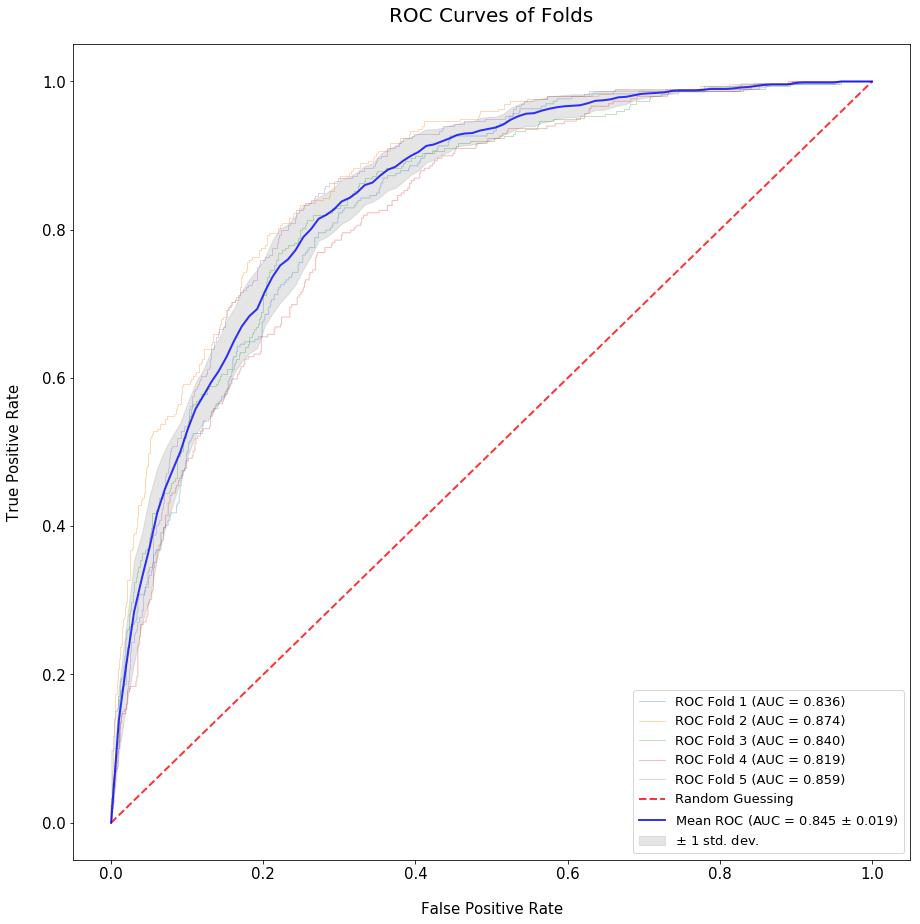

In [34]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

In [35]:
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)

# Applying logistic regression classifier
lr = LogisticRegression()  # Using default parameters.
lr.fit(x_train_scaled, y_train)  # training the model with X_train, y_train

# Generate Confusion Matrix
y_pred = lr.predict(x_test_scaled)                # Make predictions on test set
y_pred = pd.Series(y_pred)
y_test = pd.Series(y_test)
pd.crosstab(y_pred, y_test, rownames=['Predicted'], colnames=['True'], margins=True)

c:\users\work-pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


True,0,1,All
Predicted,,,
0,917,160,1077
1,116,214,330
All,1033,374,1407


Print summary statistics:

In [36]:
def print_summary_stats(y_pred, y_test):
    TP = sum((y_pred == y_test) & (y_pred == 1))            # No. of True Positives
    FN = sum((y_pred != y_test) & (y_pred == 0))            # No. of False Negatives
    P = TP + FN                                             # Total No. of Positives
    TN = sum((y_pred == y_test) & (y_pred == 0))            # No. of True Negatives
    FP = sum((y_pred != y_test) & (y_pred == 1))
    N = TN + FP

    print("Sensitivity: {}".format(TP / P))                 # True Positive / Positive (Sensitivity)
    print("Specificity: {}".format(TN / N))                 # TN / N (Specificity)
    print("Precision: {}".format(TP / (TP + FP)))           # (TP/ (TP+FP)) Precision
    print("True Negative Rate: {}".format(TN / (TN + FN)))  # (TN / (TN+FN))
    print("Overall Accuracy: {}".format(sum(y_pred == y_test)/len(y_test)))

In [37]:
print_summary_stats(y_pred, y_test)

Sensitivity: 0.5721925133689839
Specificity: 0.8877057115198451
Precision: 0.6484848484848484
True Negative Rate: 0.851439182915506
Overall Accuracy: 0.8038379530916845


Save scaler and logistic baseline model:

In [38]:
MODEL_DIR = 'models/'
joblib.dump(ss, MODEL_DIR + 'scaler_5_oct_19.pkl')
joblib.dump(lr, MODEL_DIR + 'lr_model_5_oct_19.pkl')

['models/lr_model_5_oct_19.pkl']

## 3.2.1 Logistic Regression Feature Importance <a name=lrfi></a>

* tenure is the most important explanatory feature, with people having longer tenure being less likely to be churned (negative coef)

* TotalCharges is second most important, the higher the customer is charged to date, the more likely the customer will churn

* People with 2 year contracts are also less likely to be churned, which makes intuitive business sense, given they may have to pay a higher penalty if they renage

* People with month-to-month contract are more likely to be churned

* People with DSL are less likely to be churned while people with Fibre optic are more likely to be churned. This is surprising and could be perhaps due to fibre optic being more popular nowadays and hence many companies have promotions to switch to a newer fibre optic service.

* Monthly charges is surprising as people with higher Monthly charge are less likely to switch according to the negative coefficient. These could mean that people are willing to pay for more premium services monthly as long as those services are worthwhile

* PaperlessBilling increases convenience, which fits the intuition that people with paperless bills ar e less likely to churn

* People with no online security are more likely to churn which would make sense as they might go for services with online security, changing their current plan/contract. The telco can target these people by proving promotions to these people to upgrade their security

* People with automatic bank transfers as payment, are more likely to switch

In [98]:
feats = df.drop(columns=['Churn'])
num_features = len(feats.columns)

coef_info = []
for i in range(num_features):
    coef = lr.coef_[0][i]
    coef_info.append((feats.columns[i], coef))

In [102]:
sorted(coef_info, key=lambda x: abs(x[1]), reverse=True)[:10]

[('tenure', -1.3483270539450802),
 ('TotalCharges', 0.6440802264869211),
 ('Contract_3', -0.3258935352526343),
 ('Contract_1', 0.3211515784235463),
 ('InternetService_2', 0.23767961471717655),
 ('InternetService_1', -0.2034277021989311),
 ('MonthlyCharges', -0.16299390688245258),
 ('PaperlessBilling', 0.14269065260450023),
 ('OnlineSecurity_1', 0.11739058113600169),
 ('PaymentMethod_3', 0.11289756295477796)]

## 3.3 Random Forest <a name="randfor"></a>

* The AUC score and ROC curve is pretty similar to the LogisticRegression model results earlier
* In terms of true positives, Random Forest fared worse than LogisticRegression with a sensitivity score of ~0.505
* Moreover, LogisticRegression has a higher accuracy than RandomForest (~80% as compared to 79.4%)

In [39]:
param_grid = { 
    'n_estimators': [200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [40]:
rfc = RandomForestClassifier(random_state=seed)
cv_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, cv= 5, n_jobs=-1)
cv_rfc.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [200, 500, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [41]:
cv_rfc.best_params_

{'n_estimators': 1000,
 'max_features': 'sqrt',
 'max_depth': 8,
 'criterion': 'gini'}

In [42]:
skf = StratifiedKFold(n_splits=5)
fprs, tprs, scores, val_auc_scores = [], [], [], []
for train_index, valid_index in skf.split(x_train, y_train):
    x_pseudo_train, x_pseudo_valid = x_train[train_index], x_train[valid_index]
    y_pseudo_train, y_pseudo_valid = y_train[train_index], y_train[valid_index]
    ss = StandardScaler()
    x_pseudo_train_scaled = ss.fit_transform(x_pseudo_train)
    x_pseudo_valid_scaled = ss.transform(x_pseudo_valid)
    rf = RandomForestClassifier(**cv_rfc.best_params_)  # Using default parameters.
    rf.fit(x_pseudo_train_scaled, y_pseudo_train)
    y_pred_train_probs = rf.predict_proba(x_pseudo_train_scaled)[:, 1]
    y_pred_valid_probs = rf.predict_proba(x_pseudo_valid_scaled)[:, 1]
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_pseudo_train, 
                                                 y_pred_train_probs)
    trn_auc_score = auc(trn_fpr, trn_tpr)
    val_fpr, val_tpr, val_thresholds = roc_curve(y_pseudo_valid, 
                                                 y_pred_valid_probs)
    val_auc_score = auc(val_fpr, val_tpr)
    val_auc_scores.append(val_auc_score)
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)

In [43]:
average_val_auc = np.mean(val_auc_scores)
print("Average Validation AUC score: {}".format(average_val_auc))

Average Validation AUC score: 0.8470932162899739


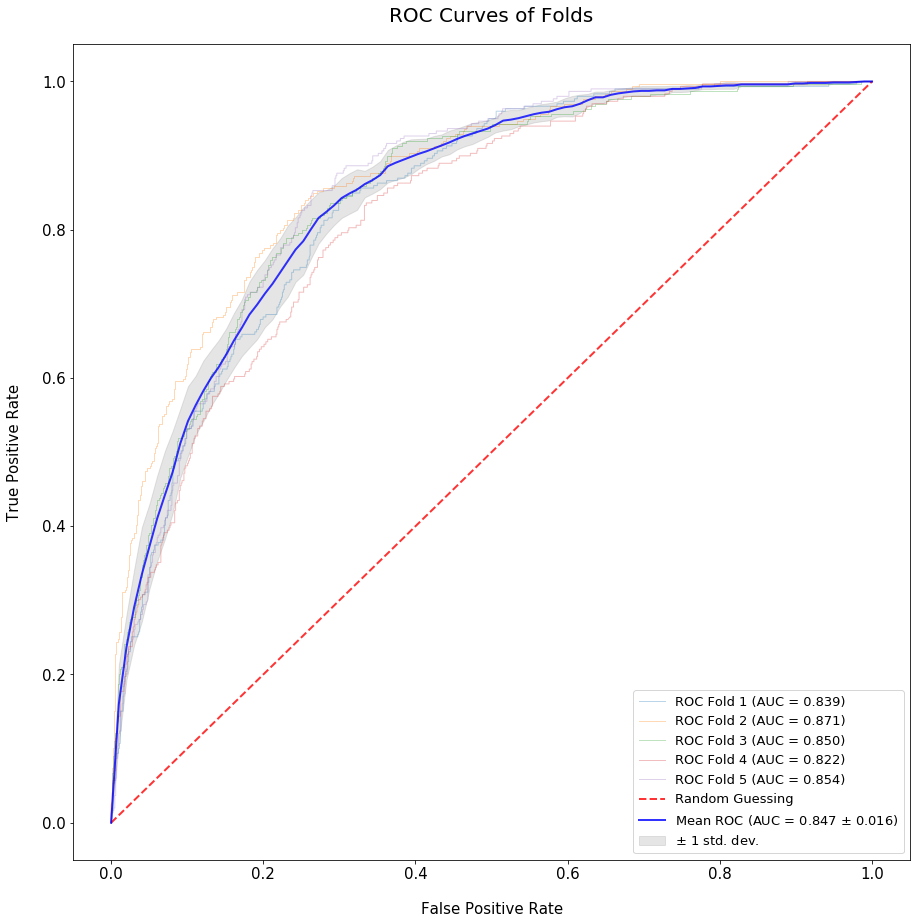

In [44]:
plot_roc_curve(fprs, tprs)

In [45]:
# Applying random forest classifier
rf = RandomForestClassifier(**cv_rfc.best_params_)  # Using CV grid search
rf.fit(x_train_scaled, y_train)  # training the model with X_train, y_train

# Generate Confusion Matrix
y_pred = rf.predict(x_test_scaled)                # Make predictions on test set
y_pred = pd.Series(y_pred)
y_test = pd.Series(y_test)
pd.crosstab(y_pred, y_test, rownames=['Predicted'], colnames=['True'], margins=True)

True,0,1,All
Predicted,,,
0,927,185,1112
1,106,189,295
All,1033,374,1407


In [46]:
print_summary_stats(y_pred, y_test)

Sensitivity: 0.5053475935828877
Specificity: 0.8973862536302033
Precision: 0.6406779661016949
True Negative Rate: 0.8336330935251799
Overall Accuracy: 0.7931769722814499


In [47]:
joblib.dump(rf, MODEL_DIR + 'rf_model_5_oct_19.pkl')

['models/rf_model_5_oct_19.pkl']

## 3.4 Model Ensembling <a name="ens"></a>

* Overall accuracy did not improve. Results obtained from LogisticRegression were still the best with accuracy above 80%. Ensembling only achieved an accuracy ~79.8%

In [85]:
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(**cv_rfc.best_params_)
clf2 = LogisticRegression()
eclf1 = VotingClassifier(estimators=[('rf', clf1), ('lr', clf2)], voting='soft')
eclf1.fit(x_train_scaled, y_train)
predictions = eclf1.predict(x_test_scaled)

c:\users\work-pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [86]:
print_summary_stats(predictions, y_test)

Sensitivity: 0.5347593582887701
Specificity: 0.89351403678606
Precision: 0.6451612903225806
True Negative Rate: 0.8413855970829535
Overall Accuracy: 0.7981520966595593


## 4. Conclusion <a name=concl></a>

In short, as a result of this exercise, we have accomplished 2 things

1. Identify customers with most important attributes that are likely to churn. (See [Logistic Regression Feature Importance](#lrfi)). The telco can target customers with such characteristics with strategic pricing or promotional packages. Such segmentation will help optimize the telco's efforts to retain customers

2. Train a model to predict churn based on customer characteristics. This is important in targeting new customers as well. If the telco knows that the customer will likely churn based on these characteristics, it would not be wise to reach out to these customers as they may renege or switch telco soon.

Next steps?

We can:

1. Try Oversampling Techniques to improve modelling accuracy, given that the target variable is imbalanced (ie. SMOTE).

2. Improve Predictive Accuracy by using a more advanced model (i.e. XGBoost)
3. More In-depth customer segmentation, design of promotional package to retain existing customers and attract new customers